# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.431450918249325

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    if num_runs < 1:
        return ValueError
    
    # ошибки будем накапливать на каждой итерации
    error = np.zeros(X.shape[0])
    
    # здесь будем считать сколько раз тот или иной объект попал в out-of-bag
    counts = np.zeros(X.shape[0])
    
    preds = np.zeros(X.shape[0]) # суммы предсказаний по всем объектам
    
    preds_sq = np.zeros(X.shape[0]) # суммы квадратов предсказаний по всем объектам 
    
    for s in range(num_runs):
        # генерим бутстрап
        indices = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
        sample = X[indices]
        answers = y[indices]
        
        # инициализируем также out-of-bag выборку
        out_of_bag = np.setdiff1d(np.arange(X.shape[0]), indices)
        X_out_of_bag = X[out_of_bag]
        y_out_of_bag = y[out_of_bag]
        
        
        # обучаем на бустрап-выборке алгоритм
        model = regressor.fit(sample, answers)
        
        # делаем предсказания для out-of-bag
        preds_s = model.predict(X_out_of_bag)
        
        # накопим переменные
        error[out_of_bag] += (preds_s - y_out_of_bag) ** 2
        preds[out_of_bag] += preds_s
        preds_sq[out_of_bag] += (preds_s) ** 2
        counts[out_of_bag] = counts[out_of_bag] + 1

    
    # отсеем те что не попали в аут оф бег 
    entered_out_of_bag = (counts > 0)
    preds = preds[entered_out_of_bag]
    preds_sq = preds_sq[entered_out_of_bag]
    counts = counts[entered_out_of_bag]
    
    y = y[entered_out_of_bag]
    
    # посчитаем средние ответы и квадраты ответов по каждому объекту
    preds_mean = preds / counts
    preds_sq_mean = preds_sq / counts
    
    # посчитаем bias и variance для каждого объекта
    biases = (y - preds_mean) ** 2
    variances = preds_sq_mean - ((preds_mean ** 2))
    
    bias = np.mean(biases)
    variance = np.mean(variances)
    
    error = np.mean(error[entered_out_of_bag] / counts)
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
import warnings
warnings.simplefilter('ignore')

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linreg = LinearRegression()
print('Linreg bias, variance, error: {}'.format(compute_biase_variance(linreg, X, y)))

tree = DecisionTreeRegressor()
print("Tree bias, variance, error: {}".format(compute_biase_variance(tree, X, y)))

random_forest = RandomForestRegressor()
print("Random forest bias, variance, error: {}".format(compute_biase_variance(random_forest, X, y)))

Linreg bias, variance, error: (23.69992685915024, 0.9258937774453637, 24.625820636595595)
Tree bias, variance, error: (9.887208453212091, 13.113687767345933, 23.000896220557983)
Random forest bias, variance, error: (10.600736039029952, 3.4049143527291994, 14.005650391759191)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ всё согласуется с тем, что мы обсуждали на занятиях. Линейная регрессия имеет низкий разброс, но очень большое смещение. У дерева смещение поменьше, но больше разброс, ведь оно более чувствительно к изменениям в выборке. Ансамблирование помогло уменьшить разброс (как и ожидалось), но, естественно, смещение не уменьшило

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [10]:
from sklearn.ensemble import BaggingRegressor
linreg_bagging = BaggingRegressor(LinearRegression())
tree_bagging = BaggingRegressor(DecisionTreeRegressor())
forest_bagging = BaggingRegressor(RandomForestRegressor())

print('Linreg bagging bias, variance, error: {}'.format(compute_biase_variance(linreg_bagging, X, y)))
print('Tree bagging bias, variance, error: {}'.format(compute_biase_variance(tree_bagging, X, y)))
print('Forest bagging bias, variance, error: {}'.format(compute_biase_variance(forest_bagging, X, y)))

Linreg bagging bias, variance, error: (23.685275514703708, 1.0162482307783893, 24.70152374548211)
Tree bagging bias, variance, error: (10.66037624170006, 3.3804357053218435, 14.040811947021945)
Forest bagging bias, variance, error: (11.663874796965088, 1.5213681853911845, 13.185242982356307)


Теория такова, что разброс сокращается в $n$ раз, где $n$ — это количество базовых моделей в беггинге. Только вот для этого объекты и модели должны быть некоррелированы, что, естественно, не выполняется, поэтому уменьшение разброса не столь значительно, но всё же есть (у дерева и леса). При этом у леса улучшение в разбросе не слишком значительно: это беггинг над ансамблем, в общем тоже странная штука

То, что разброс почти не поменялся на линреге (и даже чуток увеличился), довольно предсказуемо: модель и так имеет низкий разброс, для неё вообще применять беггинг нелогично. Грубо говоря изменениями в выборке мы чуть меняем наклон прямой

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [54]:
import matplotlib.cm as cm

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=plt):
    """
    plot graphics described above
    """
    ax.set_ylim(ymin=y.min() - 0.1 * np.abs(y.min()), ymax=y.max() + 0.1 * np.abs(y.max()))
    colors = np.arange(num_test_objects)
    # test-train split
    test_indices = np.random.choice(np.arange(X.shape[0]), size=num_test_objects)
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_train = X[np.setdiff1d(np.arange(X.shape[0]), test_indices)]
    y_train = y[np.setdiff1d(np.arange(X.shape[0]), test_indices)]
    
    for i in range(num_runs):
        # генерим бутстрап 
        indices = np.random.choice(np.arange(X_train.shape[0]), size=X_train.shape[0], replace=True)
        X_b = X_train[indices]
        y_b = y_train[indices]
        model = regressor.fit(X_b, y_b)
        pred = model.predict(X_test)
        ax.scatter(np.arange(X_test.shape[0]), pred, c=colors, cmap=cm.plasma_r)
        
    ax.scatter(np.arange(X_test.shape[0]), y_test, color='black')
    ax.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

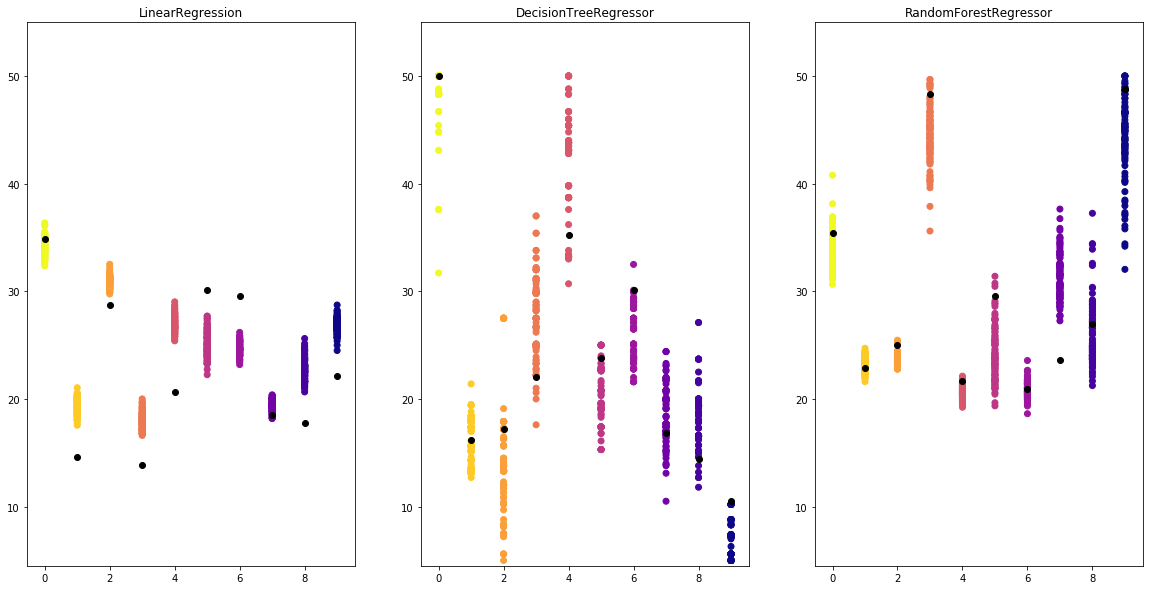

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
models = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor]
for i in range(len(models)):
    model = models[i]
    plot_predictions(model(), X, y, 100, 10, models[i].__name__, axs[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

У линейной регрессии маленький разброс, но большое смещение (бывает что прямая проходит далеко от таргета – чёрные точки часто далеко от множества цветных)

У дерева меньше смещение (как правило чёрные точки где-то среди цветных), но столбики расползаются, то есть разброс большой.

У леса смещение примерно как у дерева, но на многих объектах удалось снизить разброс (столбики более компактные)

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [59]:
depths = np.arange(1, 11)
features = np.arange(1, X.shape[1] + 1)
biases_d = []
biases_f = []
variances_d = []
variances_f = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth)
    b, v, e = compute_biase_variance(model, X, y)
    biases_d.append(b)
    variances_d.append(v)

for num_ftr in features:
    model = DecisionTreeRegressor(max_features=num_ftr)
    b, v, e = compute_biase_variance(model, X, y)
    biases_f.append(b)
    variances_f.append(v)

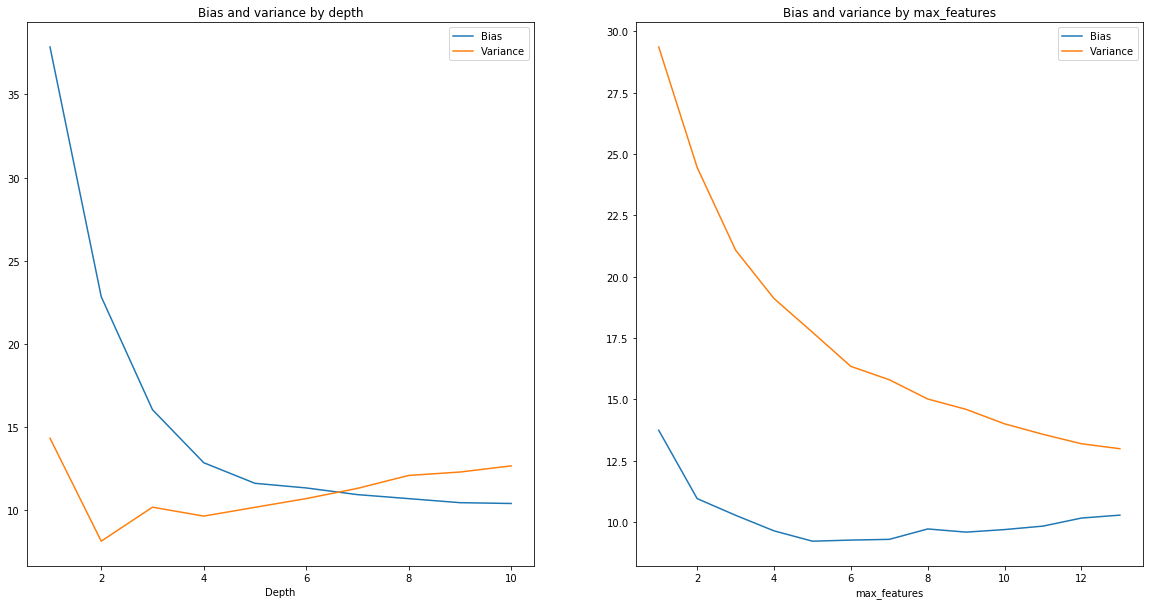

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(depths, biases_d, label='Bias')
ax[0].plot(depths, variances_d, label='Variance')
ax[0].set_title('Bias and variance by depth')
ax[0].set_xlabel('Depth')
ax[0].legend()

ax[1].plot(features, biases_f, label='Bias')
ax[1].plot(features, variances_f, label='Variance')
ax[1].set_title('Bias and variance by max_features')
ax[1].set_xlabel('max_features')
ax[1].legend()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [71]:
space = 2**np.arange(1, 10)
biases_forest = []
variances_forest = []
for n in space:
    model = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    b, v, e = compute_biase_variance(model, X, y)
    biases_forest.append(b)
    variances_forest.append(v)

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
biases_boosting = []
variances_boosting = []
for n in space:
    model = GradientBoostingRegressor(n_estimators=n)
    b, v, e = compute_biase_variance(model, X, y)
    biases_boosting.append(b)
    variances_boosting.append(v)

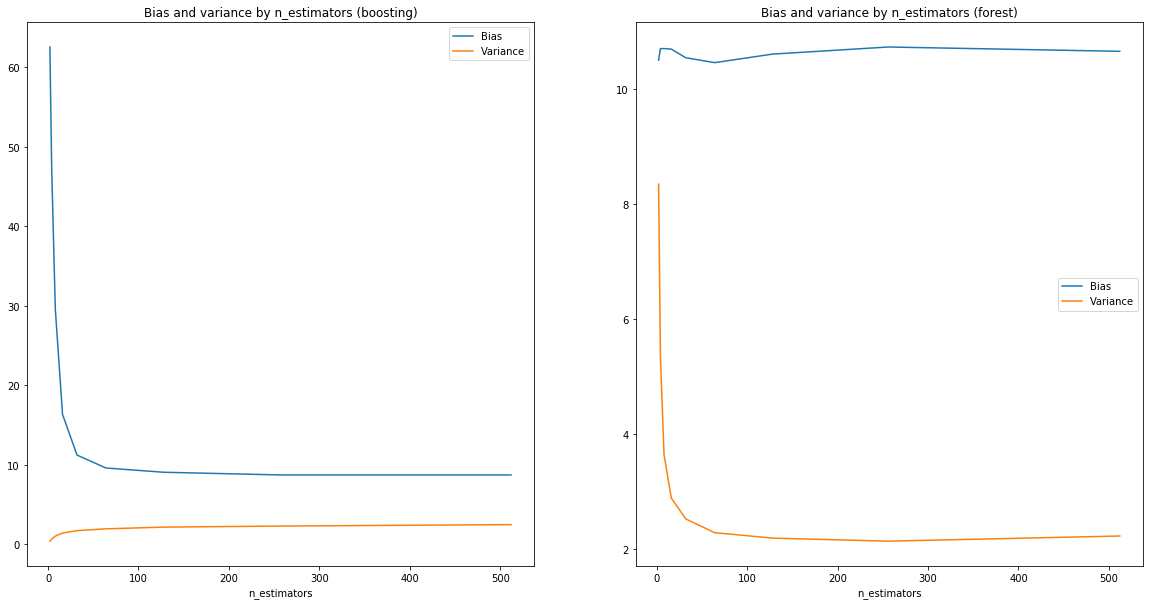

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(space, biases_boosting, label='Bias')
ax[0].plot(space, variances_boosting, label='Variance')
ax[0].set_title('Bias and variance by n_estimators (boosting)')
ax[0].set_xlabel('n_estimators')
ax[0].legend()

ax[1].plot(space, biases_forest, label='Bias')
ax[1].plot(space, variances_forest, label='Variance')
ax[1].set_title('Bias and variance by n_estimators (forest)')
ax[1].set_xlabel('n_estimators')
ax[1].legend()

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Если ограничивать глубину дерева (допустим n), то получится регрессор, дающий $2^n$ ответов. Вполне понятно, что при маленьких n плоскость будет делиться на слишком большие куски, и поэтому будет большой разброс (дерево не будет способно должным образом описать данные, ведь возможных ответов будет всего $2^n$). При этом разброс не будет большим, потому что не так много разбиений, и первые разбиения делаются на самых "больших" кластерах, которые с большой вероятностью будут представлены в бутстрапированных выборках => в каждой из них повлияют на разбиение. Из этих же соображений следует, почему уменьшается смещение и увеличивается разброс (грубо говоря, всё больше вариативности в выборе того, как разделить множество объектов, и поэтому увеличится разброс. При этом можно более подробно описать данные деревом, откуда уменьшается смещение)

Если ограничивать количество признаков, по которым делается разбиение, то понятно, что при малом количестве всё очень сильно зависит от рандома (по какому именно случайному подмножеству будет осуществляться перебор), отсюда высокий разброс, уменьшающийся с увеличением количества признаков. При этом разброс почти не меняется (грубо говоря если есть хороший признак, рано или поздно мы его зарандомим и включим в множество для перебора)

Про n_estimators. С лесом, вроде, всё понятно из лекций: если независимо обучать модели, смещение у них (и их среднего) особо не изменится, зато получится уменьшить разброс (в теории в n раз, но как я писал выше так в реальности никогда не работает). Бустинг же каждый раз усложняет модель, постоянно минимизируя ошибку, строя всё более и более сложную композицию. В итоге эта композиция может очень хорошо описывать данные, но вот разброс не уменьшается (а может и расти).

Кажется, между этими парами графиков есть взаимосвязь. Поскольку бустинг понижает смещение и не особо влияет на разброс, имеет смысл использовать в качестве кирпичиков для бустинга деревья, которые имеют большое смещение и маленький разброс — как раз неглубокие (вроде где-то читал что иногда они могут даже иметь всего 2 листа). Для леса же, наоборот, от деревьев нужно маленькое смещение, а разброс можно снизить — поэтому целесообразно использовать глубокие деревья, зачастую переобученные.